# DDACS Dataset Tutorial

This tutorial demonstrates how to work with the Deep Drawing and Cutting Simulations (DDACS) Dataset.

## Dataset Logic and Structure

### What is Deep Drawing?
Deep drawing is a manufacturing process where a sheet metal blank is formed into a hollow shape using a die and punch. The dataset captures the complete physics of this process including:

- **Material deformation**: How the metal sheet changes shape
- **Tool interaction**: Forces between forming tools and workpiece  
- **Process parameters**: Variables that control the outcome

### Data Hierarchy
```
Dataset
├── Simulations (32,071 total)
│   ├── Process Parameters (FC, MAT, STHK, BF, GEO, RAD)
│   └── Simulation Results (H5 files)
│       ├── OP10 (Forming Process)
│       │   ├── Components (blank, die, punch, binder)
│       │   └── Timesteps (0: initial → 2: max forming → 3: springback)
│       └── OP20 (Cutting Process)
            ├── Component (blank)
            └── Timesteps (0: initial → 1: springback)
```

### Physical Process Understanding
1. **Initial State (t=0)**: Flat sheet metal blank positioned above die
2. **Forming Process (t=1-2)**: Punch descends, blank deforms into die cavity
3. **Springback (t=3)**: Tools removed, material partially recovers due to elasticity
4. **Final Analysis (OP20)**: Additional springback effects during cutting operations

### Key Components
- **Blank**: The workpiece being formed (most important for analysis)
- **Die**: Lower tool that provides the cavity shape
- **Punch**: Upper tool that pushes material into die
- **Binder**: Holds blank edges to control material flow

### Process Parameters
- **FC**: Friction coefficient [0.05-0.15] - affects material flow
- **MAT**: Material scaling factor [0.9-1.1] - represents different steel grades  
- **STHK**: Sheet thickness [0.95-1.0 mm] - influences formability
- **BF**: Blank holder force [100k-500k N] - controls wrinkling vs tearing
- **GEO**: Geometry type (R/V/X) - shape complexity
- **RAD**: Characteristic radius [30-150 mm] - corner sharpness

## Installation

```bash
pip install "git+https://github.com/BaumSebastian/Deep-Drawing-and-Cutting-Simulations-Dataset.git[examples]"
```

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import pandas as pd
from pathlib import Path
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

from ddacs import DDACSDataset
from ddacs.utils import extract_point_cloud, extract_mesh, display_structure, extract_element_thickness

In [2]:
# Setup data directory
data_dir = Path("./../data")

# Load dataset
dataset = DDACSDataset(data_dir, "h5")
print(f"Loaded {len(dataset)} simulations")

# Get a sample simulation
sim_id, metadata, h5_path = dataset[200]
print(f"Sample simulation: {sim_id}")
print(f"File: {h5_path}")
print(f"Metadata: {metadata}")

Loaded 1443 simulations
Sample simulation: 16239
File: ..\data\h5\16239.h5
Metadata: ['R' np.int64(30) np.float64(0.9) np.float64(0.07) np.float64(0.97)
 np.float64(100000.0)]


## 2. Understanding the Metadata

The metadata contains the process and geometry parameters that define each simulation.

In [3]:
# Load and analyze metadata
df = dataset._metadata
print(f"Metadata structure:")
print(f"  Total simulations: {len(df)}")
print(f"  Columns: {list(df.columns)}")
print("  > Note: The column 'ID' is not returned in dataset.")

# Show parameter meanings and ranges
print(f"\nParameters (physical values):")

# Note: Update these when you have the actual unnormalized data
desc = dataset.get_metadata_descriptions()
for key in desc:
    print(f"  > {key:4} - {desc[key]}")

print(f"\nSample simulations:")
print(df.head())

Metadata structure:
  Total simulations: 1443
  Columns: ['ID', 'GEO', 'RAD', 'MAT', 'FC', 'SHTK', 'BF']
  > Note: The column 'ID' is not returned in dataset.

Parameters (physical values):
  > GEO  - Shape type (R=Rectangular, V=Concave, X=Convex)
  > RAD  - Characteristic radius [30-150 mm]
  > MAT  - Material scaling factor [0.9-1.1]
  > FC   - Friction coefficient [0.05-0.15]
  > SHTK - Sheet thickness [0.95-1.0 mm]
  > BF   - Blank holder force [100,000-500,000 N]

Sample simulations:
      ID GEO  RAD  MAT    FC  SHTK        BF
0  16039   R   30  0.9  0.05  0.95  100000.0
1  16040   R   30  0.9  0.06  0.95  100000.0
2  16041   R   30  0.9  0.07  0.95  100000.0
3  16042   R   30  0.9  0.08  0.95  100000.0
4  16043   R   30  0.9  0.09  0.95  100000.0


## 3. Understanding the Simulation Data Structure

### HDF5 File Organization
Each simulation is stored as an HDF5 file containing:

```
simulation.h5
├── OP10/ (Main forming process)
│   ├── blank/     (11k nodes, 4 timesteps) - The workpiece
│   ├── die/       (1k nodes, 3 timesteps)  - Lower tool
│   ├── punch/     (500 nodes, 3 timesteps) - Upper tool  
│   └── binder/    (100 nodes, 3 timesteps) - Edge clamp
└── OP20/ (Springback analysis)
    └── blank/     (11k nodes, 2 timesteps) - Post-forming behavior
```

To display all information use `display_structure(h5_path)`.
### Critical Timestep Understanding
- **Tools have 3 timesteps** (0, 1, 2): They are removed before final springback
- **Blank has 4 timesteps** (0, 1, 2, 3): Includes springback after tool removal
- **Timestep 3**: Maximum forming depth (tools fully engaged)
- **Timestep 4**: Springback state (tools removed, blank partially recovers)

**Important**: Using `timestep=-1` gives different results for tools vs blank due to different timestep counts.

In [4]:
# Explore the HDF5 simulation structure
with h5py.File(h5_path, 'r') as f:
    print("Operations:", list(f.keys()))

    # OP10: Forming operation
    print("\nOP10 - Forming Operation:")
    op10 = f['OP10']
    print("  Components:", list(op10.keys()))

    # Analyze each component
    print("\nComponent Details:")
    for component in ['blank', 'die', 'binder', 'punch']:
        if component in op10:
            comp = op10[component]
            nodes = comp['node_coordinates'].shape[0]

            if 'node_displacement' in comp:
                disp_shape = comp['node_displacement'].shape
                timesteps = disp_shape[0] if len(disp_shape) == 3 else 1
                print(f"  {component}: {nodes} nodes, {timesteps} timesteps")
            else:
                print(f"  {component}: {nodes} nodes, no displacement")

    # OP20: Springback operation (if exists)
    if 'OP20' in f:
        print("\nOP20 - Springback Operation:")
        op20 = f['OP20']
        print("  Components:", list(op20.keys()))
        if 'blank' in op20:
            springback_shape = op20['blank']['node_displacement'].shape
            print(f"  Springback timesteps: {springback_shape[0]}")

# For whole content use display_structure
# display_structure(h5_path)

Operations: ['OP10', 'OP20']

OP10 - Forming Operation:
  Components: ['binder', 'blank', 'die', 'general', 'punch']

Component Details:
  blank: 11236 nodes, 4 timesteps
  die: 1218 nodes, 3 timesteps
  binder: 114 nodes, 3 timesteps
  punch: 599 nodes, 3 timesteps

OP20 - Springback Operation:
  Components: ['blank']
  Springback timesteps: 2


## 4. Visualization Examples

The following sections demonstrate different visualization approaches for the simulation data.

In [5]:
try:
    import scienceplots
    plt.style.use(['science'])
except ImportError as exc:
    print("For proper plotting, use scienceplots")

# Standard figure sizes (width, height) in inches
FIGURE_SIZES = {
    'single_col': (3.5, 2.6),      # Single column
    'single_col_cb': (5, 3.5),      # Single column, with colorbar
    'single_col_tall': (3.5, 3.5), # Single column, square-ish
    'double_col': (7.0, 3.0),      # Double column, wide
    'double_col_tall': (7.0, 4.5), # Double column, taller
    'square': (3.5, 3.5),          # Square single column
    'poster': (10, 8),             # For presentations/posters
}

# Visualization constants for consistency
FIGURE_SIZE = FIGURE_SIZES['double_col']
FIGURE_DPI = 150
AXIS_LIMITS = [0, 150]
VIEW_ELEVATION = 30
VIEW_AZIMUTH = 45
TIMESTEP_MAX_FORMING = 2

# Component settings
COMPONENT_COLORS = {'blank': 'red', 'die': 'blue', 'punch': 'green', 'binder': 'orange'}
COMPONENT_NAMES = {'blank': 'Blank (Workpiece)', 'die': 'Die (Lower Tool)',
                   'punch': 'Punch (Upper Tool)', 'binder': 'Binder (Clamp)'}

blank: 11236 nodes
die: 1218 nodes
punch: 599 nodes
binder: 114 nodes


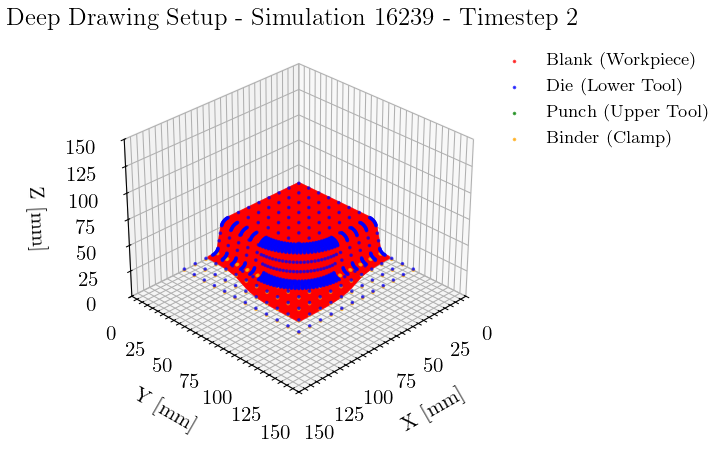

In [6]:
# Visualize complete forming setup
fig = plt.figure(figsize=FIGURE_SIZE, dpi=FIGURE_DPI)
ax = fig.add_subplot(111, projection='3d')

for component in COMPONENT_COLORS.keys():
    try:
        coords = extract_point_cloud(h5_path, component, timestep=TIMESTEP_MAX_FORMING)
        ax.scatter(coords[:, 0], coords[:, 1], coords[:, 2],
                  c=COMPONENT_COLORS[component], label=COMPONENT_NAMES[component],
                  s=0.5, alpha=0.7)
        print(f"{component}: {coords.shape[0]} nodes")
    except Exception as e:
        print(f"Could not load {component}: {e}")

ax.set_title(f'Deep Drawing Setup - Simulation {sim_id} - Timestep {TIMESTEP_MAX_FORMING}')
ax.set_xlabel('X [mm]')
ax.set_ylabel('Y [mm]')
ax.set_zlabel('Z [mm]')
ax.set_xlim(AXIS_LIMITS)
ax.set_ylim(AXIS_LIMITS)
ax.set_zlim(AXIS_LIMITS)
ax.view_init(VIEW_ELEVATION, VIEW_AZIMUTH)
ax.legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize='small')
plt.tight_layout()
plt.show()

Mesh: 11236 vertices, 22050 faces


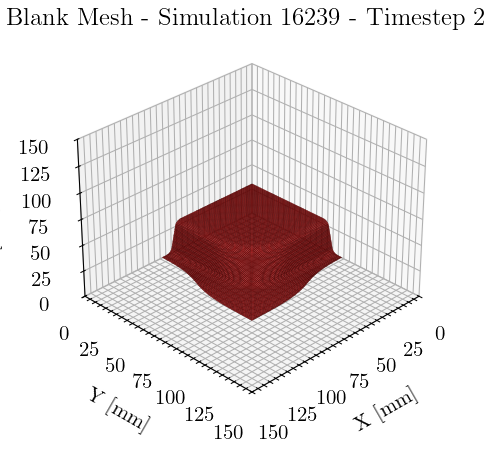

In [8]:
# Mesh visualization of blank component
fig = plt.figure(figsize=FIGURE_SIZE, dpi=FIGURE_DPI)
ax = fig.add_subplot(111, projection='3d')

vertices, triangles = extract_mesh(h5_path, 'blank', timestep=TIMESTEP_MAX_FORMING)
faces = vertices[triangles]

mesh = Poly3DCollection(faces, alpha=0.8, facecolor=COMPONENT_COLORS['blank'],
                       edgecolor='black', linewidth=0.1)
ax.add_collection3d(mesh)

print(f"Mesh: {vertices.shape[0]} vertices, {triangles.shape[0]} faces")

ax.set_title(f'Blank Mesh - Simulation {sim_id} - Timestep {TIMESTEP_MAX_FORMING}')
ax.set_xlabel('X [mm]')
ax.set_ylabel('Y [mm]')
ax.set_zlabel('Z [mm]')
ax.set_xlim(AXIS_LIMITS)
ax.set_ylim(AXIS_LIMITS)
ax.set_zlim(AXIS_LIMITS)
ax.view_init(VIEW_ELEVATION, VIEW_AZIMUTH)
plt.tight_layout()
plt.show()

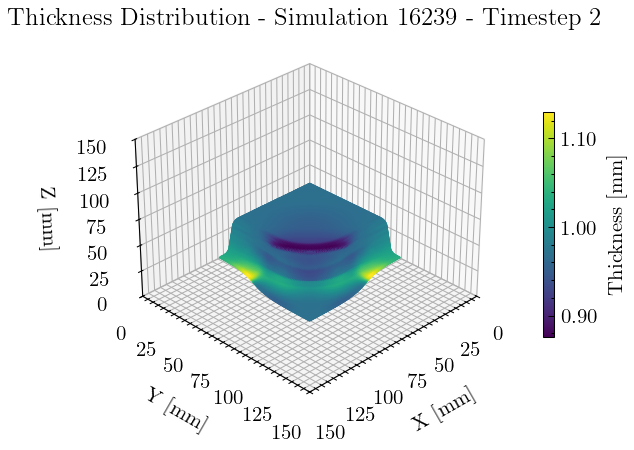

Thickness range: 0.8758 - 1.1296 mm


In [9]:
from matplotlib import ticker

# Thickness visualization
timestep = TIMESTEP_MAX_FORMING
vertices, triangles = extract_mesh(h5_path, 'blank', timestep=timestep)
thickness = extract_element_thickness(h5_path, 'blank', timestep=timestep)
# Map element data to triangles
thickness_per_triangle = np.repeat(thickness, 2)[:len(triangles)]

fig = plt.figure(figsize=FIGURE_SIZE, dpi=FIGURE_DPI)
ax = fig.add_subplot(111, projection='3d')

faces = vertices[triangles]
norm_thickness = (thickness_per_triangle - thickness.min()) / (thickness.max() - thickness.min())
colors = plt.cm.viridis(norm_thickness)

collection = Poly3DCollection(faces, facecolors=colors, edgecolors=colors, alpha=1)
ax.add_collection3d(collection)

# Add colorbar
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(thickness.min(), thickness.max()))
cbar = plt.colorbar(sm, ax=ax, shrink=0.6)
cbar.ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
cbar.set_label('Thickness [mm]')

ax.set_title(f'Thickness Distribution - Simulation {sim_id} - Timestep {timestep}')
ax.set_xlabel('X [mm]')
ax.set_ylabel('Y [mm]')
ax.set_zlabel('Z [mm]')
ax.set_xlim(AXIS_LIMITS)
ax.set_ylim(AXIS_LIMITS)
ax.set_zlim(AXIS_LIMITS)
ax.view_init(VIEW_ELEVATION, VIEW_AZIMUTH)
plt.tight_layout()
plt.show()

print(f"Thickness range: {thickness.min():.4f} - {thickness.max():.4f} mm")